# USG 제조 현장 이미지 탐지 Base_Line

&nbsp;

## 패키지 불러오기

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import save_image
from PIL import Image
import pandas as pd
import random
from google.colab import files

## GPU setting
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## seed 고정
random.seed(20230308)
np.random.seed(20230308)
torch.manual_seed(20230308)
torch.cuda.manual_seed_all(20230308)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

&nbsp;

## 데이터 다운로드

In [ ]:
!pip install --upgrade --no-cache-dir gdown

import gdown

id = '1kznBaHCq2N_KeSMsKVnP5QjxQU0FlxyA'
output = 'usg1_data.zip'
gdown.download(id=id, output=output, quiet=False)
!unzip -qq "/content/usg1_data.zip"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


Downloading...
From: https://drive.google.com/uc?id=1kznBaHCq2N_KeSMsKVnP5QjxQU0FlxyA
To: /content/usg1_data.zip
100%|██████████| 49.8M/49.8M [00:00<00:00, 77.4MB/s]


&nbsp;

## 데이터 train : valid

In [ ]:
def train_val_split(image_dir, ratio, transforms, batch):
    train_data = datasets.ImageFolder(image_dir, transforms)
    train_val_ratio = ratio

    # train, val 분할
    num_train = len(train_data)
    indices = list(range(num_train))

    np.random.shuffle(indices) # shuffle
    split = int(np.floor(train_val_ratio * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # batch sampler 정의
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # dataloader
    train_loader = DataLoader(train_data,
                            batch_size = batch,
                            sampler = train_sampler,
                            num_workers = 2)
    val_loader = DataLoader(train_data,
                            batch_size = batch,
                            sampler = valid_sampler,
                            num_workers = 2)

    return train_loader, val_loader , train_data.classes

In [ ]:
data_transforms = transforms.Compose([
          transforms.Resize((128,128)),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])

img_path = './usg1_data/dataset/'
train_loader, val_loader, class_name = train_val_split(img_path, 0.2, data_transforms, 64)

&nbsp;

## Batch 데이터 확인하기

In [ ]:
def show_image(image):
    image_test = image.numpy().transpose((1,2,0))
    mean = np.array([0.5])
    std = np.array([0.5])
    image_test = std * image_test + mean
    image_test = np.clip(image_test, 0, 1)
    plt.imshow(image_test)
    # plt.title(label)
    plt.show()

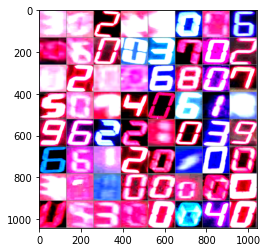

class : ['3', '0', '2', '2', '9', '0', '0', '6', '0', '6', '0', '0', '3', '7', '0', '2', '0', '2', '0', '0', '6', '8', '0', '7', '5', '0', '7', '4', '0', '6', '1', '8', '9', '6', '2', '2', '1', '0', '3', '9', '6', '6', '1', '2', '0', '1', '0', '0', '3', '0', '1', '0', '0', '0', '0', '0', '0', '5', '3', '0', '0', '0', '4', '0']


In [ ]:
# 배치별 데이터 가져오기
iterator = iter(train_loader)
# 배치 중에서 하나꺼내서 시각화
images, classes = next(iterator)
image = make_grid(images)
show_image(image)
print(f'class : {[class_name[i] for i in classes]}')

&nbsp;

## model load

In [ ]:
# 마지막 layer 변경
model_classification = torchvision.models.vgg11(pretrained=False)
last_layer = model_classification.classifier[6]
model_classification.classifier[6] = nn.Linear(last_layer.in_features, len(class_name))

# loss fn 설정
criterion = nn.CrossEntropyLoss()

# optimizer 설정
optimizer = optim.SGD(model_classification.parameters(), lr=0.1)

# gpu
model = model_classification.to(device)

# epoch
num_epochs = 100
min_loss = int(1e9)

# 조기종료 설정
counter = 0
max_counter = 10

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


- VGG16 구조

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

&nbsp;

## model train, eval 함수 설정

In [ ]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0
    corr = 0
    for img, lbl in tqdm(data_loader):
        img, lbl = img.to(device), lbl.to(device)
        optimizer.zero_grad()
        output = model(img).to(device)
        loss = loss_fn(output, lbl)
        loss.backward()
        optimizer.step()
        _, pred = output.max(dim=1)
        corr += pred.eq(lbl).sum().item()
        running_loss += loss.item() * img.size(0)
    # 누적된 정답수를 전체 개수로 나누어 주면 정확도 계산
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환
    return running_loss / len(data_loader.dataset), acc

def model_evaluate(model, data_loader, loss_fn, device):
    model.eval()
    with torch.no_grad():
        corr = 0
        running_loss = 0

        for img, lbl in tqdm(data_loader):
            img, lbl = img.to(device), lbl.to(device)
            output = model(img)
            _, pred = output.max(dim=1)
            corr += torch.sum(pred.eq(lbl)).item()
            running_loss += loss_fn(output, lbl).item() * img.size(0)
        acc = corr / len(data_loader.dataset)
        return running_loss / len(data_loader.dataset), acc

&nbsp;

## model 훈련

In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Epoch 별 훈련 및 검증을 수행
for epoch in range(num_epochs+1):

    if counter >= max_counter:
        print('조기 종료')
        break

    train_loss, train_acc = model_train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = model_evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # val_loss 가 개선되었다면 min_loss를 갱신, model의 가중치(weights)를 저장
    if val_loss < min_loss:
        print(f'model loss 갱신 {min_loss:.5f} -> {val_loss:.5f}')
        min_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
    else:
        counter +=1

    # Epoch 별 결과를 출력
    print(f'epoch {epoch + 1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

100%|██████████| 42/42 [00:04<00:00,  9.80it/s]


model loss 갱신 1000000000.00000 -> 0.42089
epoch 01, loss: 1.69368, acc: 0.23577, val_loss: 0.42089, val_accuracy: 0.05713


100%|██████████| 42/42 [00:04<00:00, 10.18it/s]


epoch 02, loss: 1.59789, acc: 0.27119, val_loss: 0.59425, val_accuracy: 0.04275


100%|██████████| 42/42 [00:04<00:00, 10.17it/s]


model loss 갱신 0.42089 -> 0.06348
epoch 03, loss: 0.94383, acc: 0.49047, val_loss: 0.06348, val_accuracy: 0.18288


100%|██████████| 42/42 [00:04<00:00, 10.21it/s]


epoch 04, loss: 0.21840, acc: 0.73525, val_loss: 0.33040, val_accuracy: 0.12962


100%|██████████| 42/42 [00:04<00:00, 10.11it/s]


model loss 갱신 0.06348 -> 0.05058
epoch 05, loss: 0.24420, acc: 0.73086, val_loss: 0.05058, val_accuracy: 0.18561


100%|██████████| 42/42 [00:04<00:00, 10.16it/s]


model loss 갱신 0.05058 -> 0.04053
epoch 06, loss: 0.09999, acc: 0.77247, val_loss: 0.04053, val_accuracy: 0.18985


100%|██████████| 42/42 [00:04<00:00, 10.16it/s]


model loss 갱신 0.04053 -> 0.03202
epoch 07, loss: 0.07804, acc: 0.77875, val_loss: 0.03202, val_accuracy: 0.19348


100%|██████████| 42/42 [00:04<00:00, 10.16it/s]


model loss 갱신 0.03202 -> 0.03200
epoch 08, loss: 0.06398, acc: 0.78170, val_loss: 0.03200, val_accuracy: 0.19212


100%|██████████| 42/42 [00:04<00:00, 10.17it/s]


model loss 갱신 0.03200 -> 0.02977
epoch 09, loss: 0.06957, acc: 0.78080, val_loss: 0.02977, val_accuracy: 0.19348


100%|██████████| 42/42 [00:04<00:00, 10.20it/s]


model loss 갱신 0.02977 -> 0.02774
epoch 10, loss: 0.05754, acc: 0.78390, val_loss: 0.02774, val_accuracy: 0.19317


100%|██████████| 42/42 [00:04<00:00, 10.13it/s]


epoch 11, loss: 0.04640, acc: 0.78730, val_loss: 0.03286, val_accuracy: 0.19333


100%|██████████| 42/42 [00:04<00:00, 10.04it/s]


epoch 12, loss: 0.03713, acc: 0.78957, val_loss: 0.03189, val_accuracy: 0.19499


100%|██████████| 42/42 [00:04<00:00, 10.18it/s]


epoch 13, loss: 0.03593, acc: 0.79101, val_loss: 0.02984, val_accuracy: 0.19469


100%|██████████| 42/42 [00:04<00:00, 10.13it/s]


epoch 14, loss: 0.02990, acc: 0.79184, val_loss: 0.03560, val_accuracy: 0.19439


100%|██████████| 42/42 [00:04<00:00, 10.10it/s]


epoch 15, loss: 0.02952, acc: 0.79146, val_loss: 0.03651, val_accuracy: 0.19454


100%|██████████| 42/42 [00:04<00:00, 10.22it/s]


epoch 16, loss: 0.02528, acc: 0.79328, val_loss: 0.02941, val_accuracy: 0.19476


100%|██████████| 42/42 [00:04<00:00, 10.20it/s]


epoch 17, loss: 0.01966, acc: 0.79479, val_loss: 0.03134, val_accuracy: 0.19454


100%|██████████| 42/42 [00:04<00:00, 10.12it/s]


epoch 18, loss: 0.01243, acc: 0.79661, val_loss: 0.04195, val_accuracy: 0.19423


100%|██████████| 42/42 [00:04<00:00, 10.13it/s]


epoch 19, loss: 0.05672, acc: 0.78526, val_loss: 0.03779, val_accuracy: 0.19355


100%|██████████| 42/42 [00:04<00:00, 10.18it/s]

epoch 20, loss: 0.03141, acc: 0.79086, val_loss: 0.03567, val_accuracy: 0.19431
조기 종료


&nbsp;

## 훈련 과정 시각화

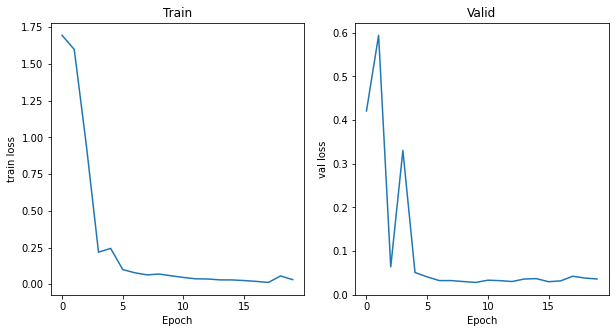

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10, 5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('train loss')
plt.plot([i for i in range(len(train_losses))],train_losses)
plt.title('Train')

plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('val loss')
plt.plot([i for i in range(len(train_losses))],val_losses)
plt.title('Valid')
plt.show()

&nbsp;

## Best Model 불러오기

In [ ]:
model_classification = torchvision.models.vgg11(pretrained=False)
last_layer = model_classification.classifier[-1]
model_classification.classifier[-1] = nn.Linear(last_layer.in_features, len(class_name))
model = model_classification.to(device)


checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint)

<All keys matched successfully>

&nbsp;

## model 예측 결과 저장

In [ ]:
arr = np.array([])
with torch.no_grad():
    model.eval()
    for i in range(100):
        img = Image.open(f'./usg1_data/test_data/test_{i}.jpg').convert('RGB')
        img = data_transforms(img)
        img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
        img = img.type(torch.float)
        img = img.to(device)
        outputs = model(img)
        _, pred = torch.max(outputs, 1)
        pred_np = pred.cpu().detach().numpy()
        arr=np.append(arr, pred_np)

arr = arr.astype(np.int32)

# 예측 저장, 해당 csv파일을 제출
y_pred = pd.DataFrame(arr)
y_pred.to_csv('y_pred.csv',index=False, header=None)

# 예측 결과 다운
files.download("y_pred.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- 예측 결과 확인

In [ ]:
y_pred

,0
0,5
1,6
2,3
3,5
4,5
...,...
95,0
96,3
97,3
98,1
